In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve


/home/user/upgrade/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('plant_growth_data.csv')


In [5]:
df.head()

,Soil_Type,Sunlight_Hours,Water_Frequency,Fertilizer_Type,Temperature,Humidity,Growth_Milestone
0,loam,5.192294,bi-weekly,chemical,31.719602,61.591861,0
1,sandy,4.033133,weekly,organic,28.919484,52.422276,1
2,loam,8.892769,bi-weekly,none,23.179059,44.660539,0
3,loam,8.241144,bi-weekly,none,18.465886,46.433227,0
4,sandy,8.374043,bi-weekly,organic,18.128741,63.625923,0


In [6]:
def get_df_info(df):
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mData types of columns:\033[0m\n", df.dtypes)
    
    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()
    
    print("\n\033[1mNumber of unique values in each column:\033[0m")
    for col in df.columns:
        print(f"\033[1m{col}\033[0m: {df[col].nunique()}")
        
    print("\n\033[1mNumber of null values in each column:\033[0m\n", df.isnull().sum())
    
    print("\n\033[1mNumber of duplicate rows:\033[0m ", df.duplicated().sum())
    
    print("\n\033[1mDescriptive statistics of DataFrame:\033[0m\n", df.describe().transpose())

# Call the function
get_df_info(df)


Shape of DataFrame:  (193, 7)

Columns in DataFrame:  ['Soil_Type', 'Sunlight_Hours', 'Water_Frequency', 'Fertilizer_Type', 'Temperature', 'Humidity', 'Growth_Milestone']

Data types of columns:
 Soil_Type            object
Sunlight_Hours      float64
Water_Frequency      object
Fertilizer_Type      object
Temperature         float64
Humidity            float64
Growth_Milestone      int64
dtype: object

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Soil_Type         193 non-null    object 
 1   Sunlight_Hours    193 non-null    float64
 2   Water_Frequency   193 non-null    object 
 3   Fertilizer_Type   193 non-null    object 
 4   Temperature       193 non-null    float64
 5   Humidity          193 non-null    float64
 6   Growth_Milestone  193 non-null    int64  
dtypes: float64(3), int64(1), object

In [7]:
# Encode categorical variables
le = LabelEncoder()
df['Soil_Type'] = le.fit_transform(df['Soil_Type'])
df['Water_Frequency'] = le.fit_transform(df['Water_Frequency'])
df['Fertilizer_Type'] = le.fit_transform(df['Fertilizer_Type'])

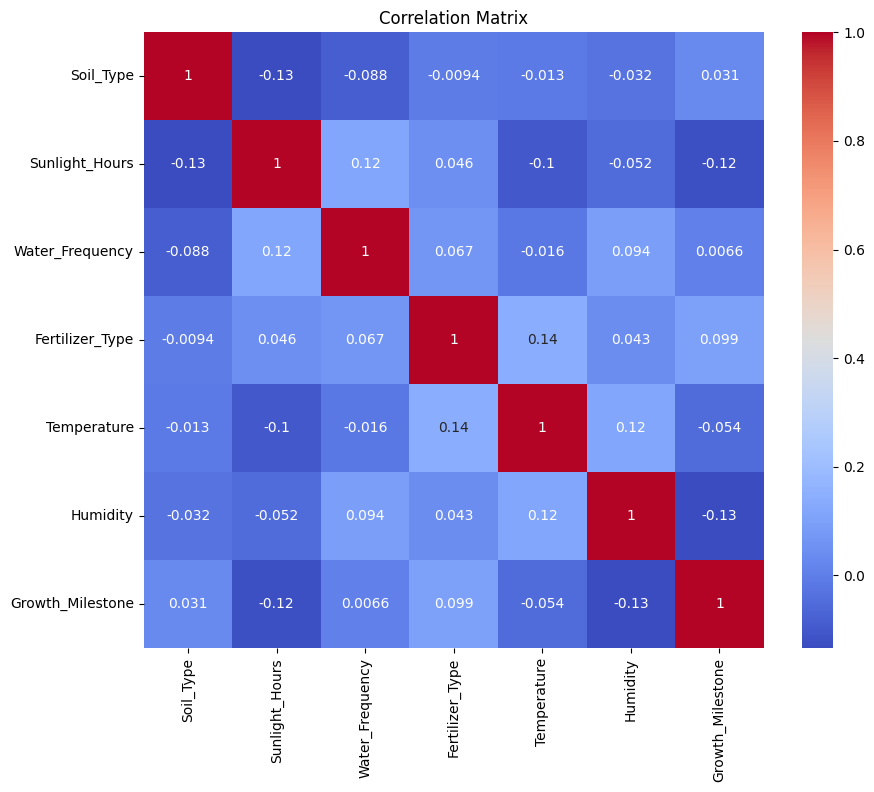

In [8]:
# Correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

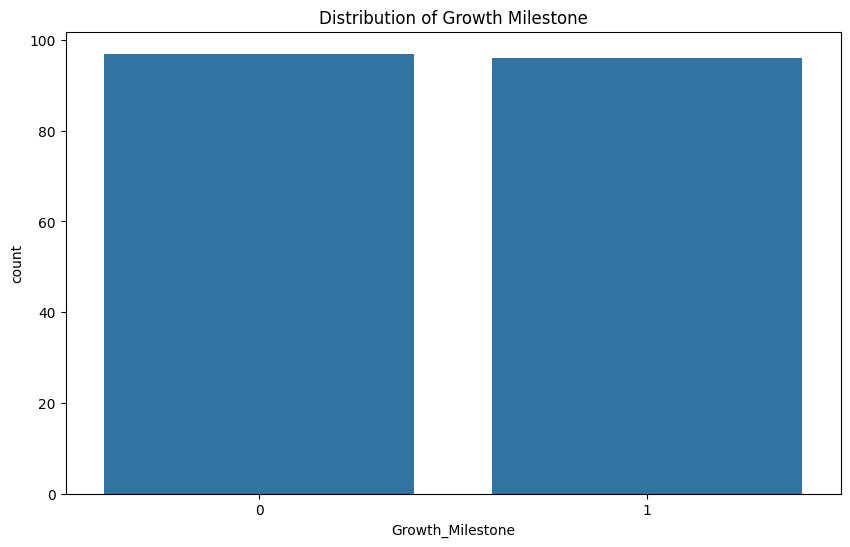

In [9]:
# Distribution of Growth_Milestone (binary)
plt.figure(figsize=(10, 6))
sns.countplot(x='Growth_Milestone', data=df)
plt.title('Distribution of Growth Milestone')
plt.show()

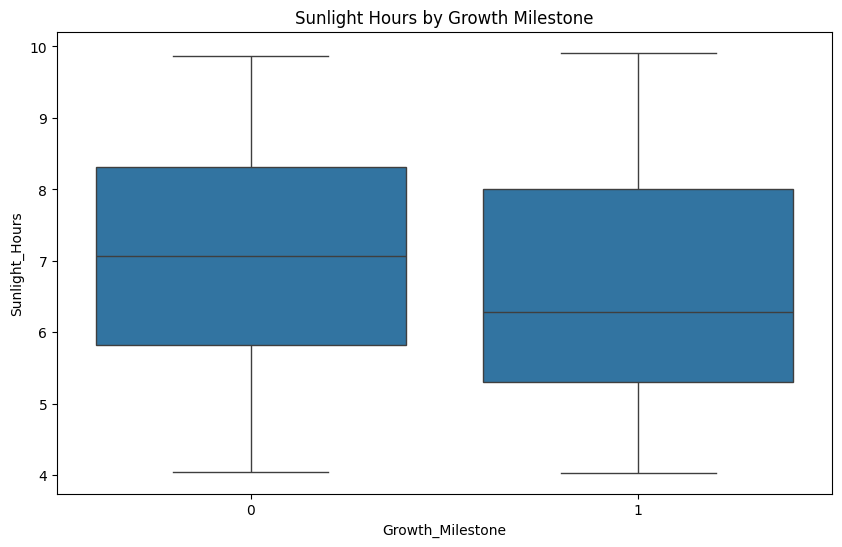

In [10]:
# Relationship between Sunlight_Hours and Growth_Milestone
plt.figure(figsize=(10, 6))
sns.boxplot(x='Growth_Milestone', y='Sunlight_Hours', data=df)
plt.title('Sunlight Hours by Growth Milestone')
plt.show()

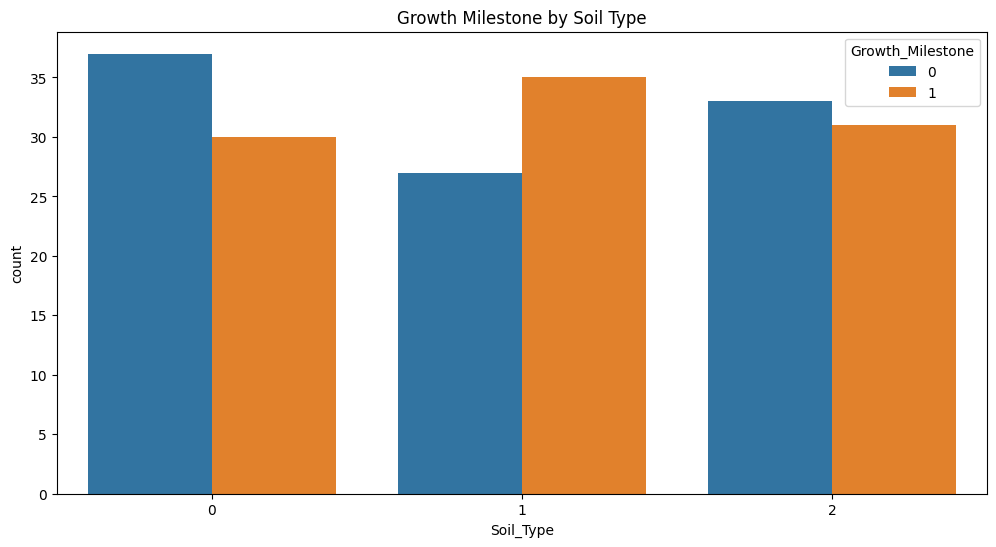

In [11]:
# Box plot of Growth_Milestone by Soil_Type
plt.figure(figsize=(12, 6))
sns.countplot(x='Soil_Type', hue='Growth_Milestone', data=df)
plt.title('Growth Milestone by Soil Type')
plt.show()

In [12]:
# Split the data
X = df.drop('Growth_Milestone', axis=1)
y = df['Growth_Milestone']

In [13]:
def apply_models(X, y):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Check for class imbalance
    class_counts = np.bincount(y_train)
    min_samples = np.min(class_counts)
    max_samples = np.max(class_counts)
    imbalance_ratio = min_samples / max_samples
    
    if imbalance_ratio < 0.5:  # Adjusted threshold
        print(f"Class imbalance detected. Imbalance ratio: {imbalance_ratio:.2f}")
        if imbalance_ratio < 0.1:
            print("Severe imbalance. Applying SMOTE...")
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)
        else:
            print("Moderate imbalance. Consider adjusting class weights in models.")
    
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and test data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the models
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs', class_weight='balanced'),
        'SVC': SVC(C=1.0, kernel='rbf', probability=True, class_weight='balanced'),
        'DecisionTree': DecisionTreeClassifier(max_depth=5, min_samples_split=2, class_weight='balanced'),
        'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced'),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=100, max_depth=10, class_weight='balanced'),
        'AdaBoost': AdaBoostClassifier(n_estimators=50, learning_rate=0.1),
        'GradientBoost': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100),
        'LightGBM': LGBMClassifier(n_estimators=100, boosting_type='gbdt'),
        'CatBoost': CatBoostClassifier(verbose=0, iterations=100)
    }

    # Initialize a dictionary to hold the performance of each model
    model_performance = {}

    # Apply each model
    for model_name, model in models.items():
        print(f"\n\033[1mClassification with {model_name}:\033[0m\n{'-' * 30}")
        
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate the accuracy and ROC AUC score
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        # Store the performance in the dictionary
        model_performance[model_name] = (accuracy, roc_auc)

        # Print the accuracy score
        print("\033[1m**Accuracy**:\033[0m\n", accuracy)

        # Print the ROC AUC score
        print("\033[1m**ROC AUC Score**:\033[0m\n", roc_auc)

        # Print the confusion matrix
        print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))

        # Print the classification report
        print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

    # Sort the models based on ROC AUC score and pick the top 3
    top_3_models = sorted(model_performance.items(), key=lambda x: x[1][1], reverse=True)[:3]
    print("\n\033[1mTop 3 Models based on ROC AUC Score:\033[0m\n", top_3_models)

    # Extract the model names and classifiers for the top 3 models
    top_3_model_names = [model[0] for model in top_3_models]
    top_3_classifiers = [models[model_name] for model_name in top_3_model_names]

    # Create a Voting Classifier with the top 3 models
    print("\n\033[1mInitializing Voting Classifier with top 3 models...\033[0m\n")
    voting_clf = VotingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)), voting='soft')
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)
    y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]
    print("\n\033[1m**Voting Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\033[1m**ROC AUC Score**:\033[0m\n", roc_auc_score(y_test, y_pred_proba))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

    # Create a Stacking Classifier with the top 3 models
    print("\n\033[1mInitializing Stacking Classifier with top 3 models...\033[0m\n")
    stacking_clf = StackingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)))
    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]
    print("\n\033[1m**Stacking Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\033[1m**ROC AUC Score**:\033[0m\n", roc_auc_score(y_test, y_pred_proba))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

In [14]:
apply_models(X, y)



Classification with LogisticRegression:
------------------------------
**Accuracy**:
 0.41025641025641024
**ROC AUC Score**:
 0.41711229946524064

**Confusion Matrix**:
 [[ 8  9]
 [14  8]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.36      0.47      0.41        17
           1       0.47      0.36      0.41        22

    accuracy                           0.41        39
   macro avg       0.42      0.42      0.41        39
weighted avg       0.42      0.41      0.41        39


Classification with SVC:
------------------------------
**Accuracy**:
 0.48717948717948717
**ROC AUC Score**:
 0.5026737967914439

**Confusion Matrix**:
 [[ 9  8]
 [12 10]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.43      0.53      0.47        17
           1       0.56      0.45      0.50        22

    accuracy                           0.49        39
   macro avg       0.49      0.49

/home/user/upgrade/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


**Accuracy**:
 0.48717948717948717
**ROC AUC Score**:
 0.5574866310160428

**Confusion Matrix**:
 [[ 5 12]
 [ 8 14]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.38      0.29      0.33        17
           1       0.54      0.64      0.58        22

    accuracy                           0.49        39
   macro avg       0.46      0.47      0.46        39
weighted avg       0.47      0.49      0.47        39


Classification with GradientBoost:
------------------------------
**Accuracy**:
 0.48717948717948717
**ROC AUC Score**:
 0.5267379679144385

**Confusion Matrix**:
 [[ 7 10]
 [10 12]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.41      0.41      0.41        17
           1       0.55      0.55      0.55        22

    accuracy                           0.49        39
   macro avg       0.48      0.48      0.48        39
weighted avg       0.49      0.49      0.4

/home/user/upgrade/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:05:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/user/upgrade/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'lscpu'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/home/user/upgrade/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 250, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subpro

**Accuracy**:
 0.46153846153846156
**ROC AUC Score**:
 0.5080213903743316

**Confusion Matrix**:
 [[ 7 10]
 [11 11]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.39      0.41      0.40        17
           1       0.52      0.50      0.51        22

    accuracy                           0.46        39
   macro avg       0.46      0.46      0.46        39
weighted avg       0.46      0.46      0.46        39


Classification with LightGBM:
------------------------------
[LightGBM] [Info] Number of positive: 74, number of negative: 80
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 154, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480519 -> initscore=-0.077962
[LightGBM] [Info] Start training fr

In [15]:
# Scale numerical features
scaler = MinMaxScaler()
numerical_features = ['Sunlight_Hours', 'Temperature', 'Humidity']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0)
    }
    
    model = ExtraTreesClassifier(**params, random_state=42)
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value:.4f}')
print('Best hyperparameters:')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2024-07-10 17:06:26,064] A new study created in memory with name: no-name-d3fadff5-0640-46bc-938a-118613912ed9
[I 2024-07-10 17:06:26,723] Trial 0 finished with value: 0.5840860215053764 and parameters: {'n_estimators': 129, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 0.6232640142029933}. Best is trial 0 with value: 0.5840860215053764.
[I 2024-07-10 17:06:27,296] Trial 1 finished with value: 0.5711827956989246 and parameters: {'n_estimators': 114, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.925199728416829}. Best is trial 0 with value: 0.5840860215053764.
[I 2024-07-10 17:06:28,136] Trial 2 finished with value: 0.5582795698924731 and parameters: {'n_estimators': 175, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.48390670337225317}. Best is trial 0 with value: 0.5840860215053764.
[I 2024-07-10 17:06:28,911] Trial 3 finished with value: 0.5967741935483871 and parameters: {'n_e

Best trial:
Accuracy: 0.6426
Best hyperparameters:
n_estimators: 246
max_depth: 21
min_samples_split: 15
min_samples_leaf: 8
max_features: 0.2720281641264128


In [16]:

# Train the final model with best parameters
best_params = study.best_params
final_model = ExtraTreesClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)

Accuracy: 0.5385

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.76      0.59        17
           1       0.67      0.36      0.47        22

    accuracy                           0.54        39
   macro avg       0.57      0.56      0.53        39
weighted avg       0.59      0.54      0.52        39



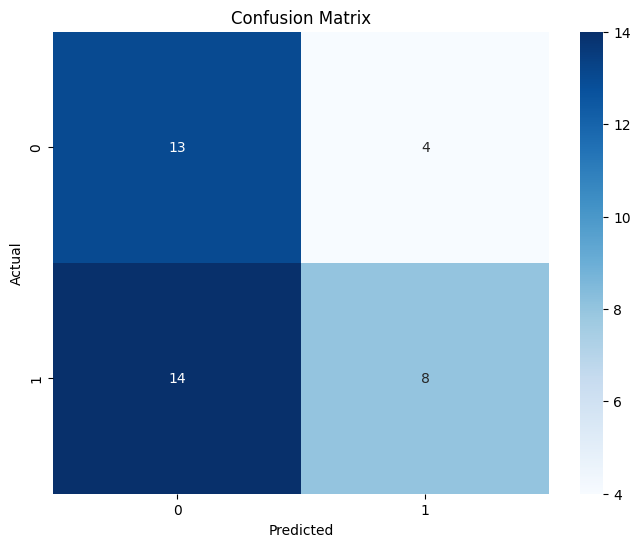

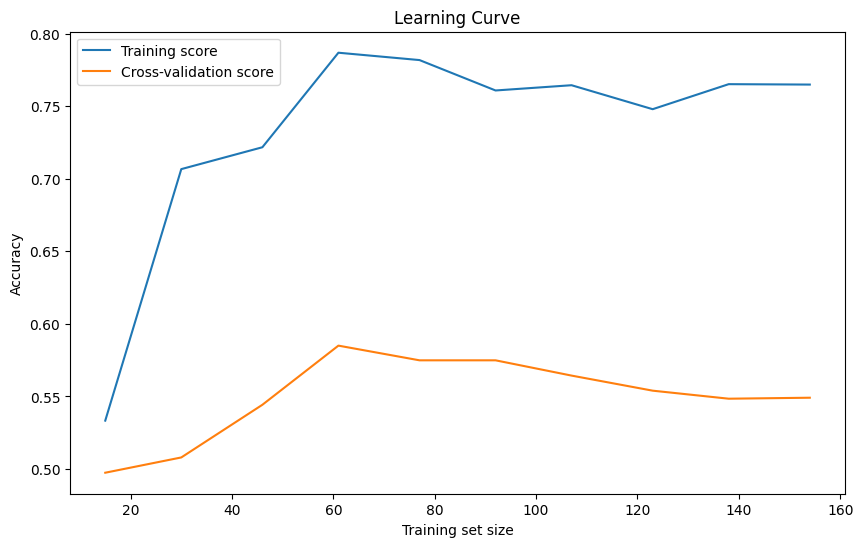

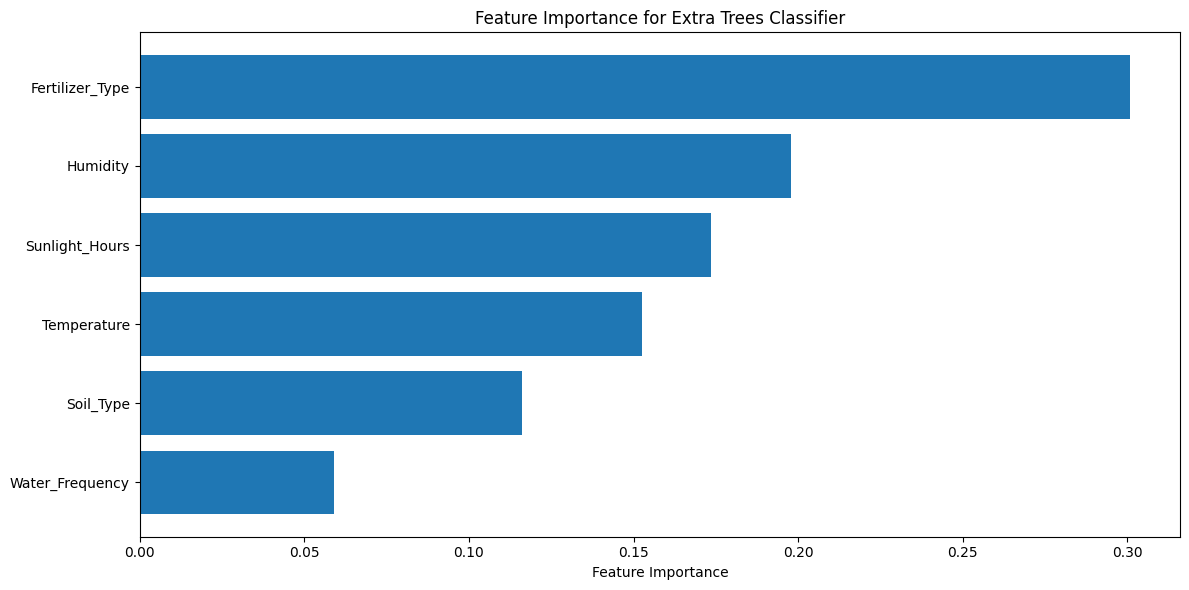

In [17]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    final_model, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Feature Importance
feature_importance = final_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Extra Trees Classifier')
plt.tight_layout()
plt.show()